# Visualizing MSI Images with Parametric UMAP.

Binning with m/z from 900 is used to create the segmentation.
Then we train parametric umap using only the non noise bins, with 1 output.

In [22]:
import numpy as np
import joblib
from sklearn.decomposition import non_negative_factorization
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image, visualizations_from_explanations
from matplotlib import pyplot as plt
from PIL import Image


NUM_COMPONENTS = 5
_cmap = plt.cm.get_cmap('gist_rainbow')
colors_for_components = [
    np.array(
        _cmap(i)) for i in np.arange(
        0,
        1,
        1.0 /
        NUM_COMPONENTS)]

# Create the segmentation mask/
img = np.load("D:\\maldi\\tol_01_binarysearch_1_bin\\0.npy")
img = img[:, :, 600 :]
H = np.load("h_cosegmentation.npy")
img = img / (1e-6 + np.median(img, axis=-1)[:, :, None])
vector = img.reshape((-1, img.shape[-1]))
w_new, h_new, n_iter = non_negative_factorization(vector, H=H, W=None, n_components=NUM_COMPONENTS, update_H=False, random_state=0)
explanations = w_new.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
explanations[4, :] = 0
spatial_sum_visualization, global_percentile_visualization, normalized_sum, normalized_percentile = visualizations_from_explanations(img, explanations, colors_for_components)
segmentation_mask = normalized_sum.argmax(axis=0)
segmentation_mask[img.max(axis=-1) == 0] = 0
display(Image.fromarray(spatial_sum_visualization))

# Create the training data from the first image.
img = np.load("D:\\maldi\\tol_None_5_bins\\0.npy")
img = img / (1e-6 + np.median(img, axis=-1)[:, :, None])
img[normalized_sum.argmax() == 3] = 0


img[segmentation_mask == 0] = 0
training_data = img[::2, ::2, :].reshape(-1, img.shape[-1])
training_data = training_data[training_data.max(axis=-1) > 0]
print(training_data.shape)

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_29304\826845256.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')


KeyboardInterrupt: 

# Define the parametric UMAP deep neural network.
5005 outputs since we use the full range.

In [ ]:
from umap.parametric_umap import ParametricUMAP
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5005,)),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1)
])

umap_model = ParametricUMAP(encoder=encoder, n_components=1, n_neighbors=50, n_training_epochs=1, dims=(5005,), run_eagerly=True).fit(training_data)

umap_model.encoder.save("D:\\maldi\\parametric_umap_tol_None_5_bins.keras")

d:\miniconda3\envs\dl\Lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] None
(11548, 5005)


KeyboardInterrupt: 

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_29304\1704540121.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')


9/9 [==============================] - 1s 82ms/step
Colored image without region specific normalization


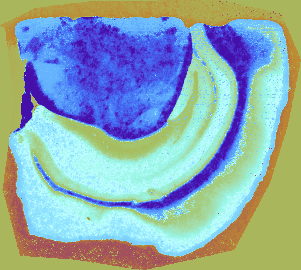

1D UMAP with per region color mapping


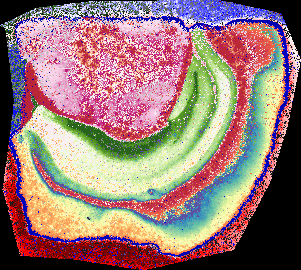

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_29304\1704540121.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')


10/10 [==============================] - 2s 102ms/step
Colored image without region specific normalization


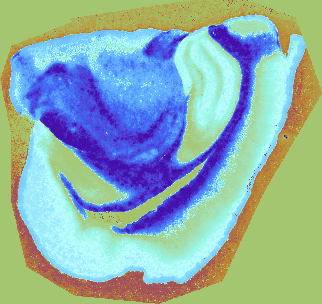

1D UMAP with per region color mapping


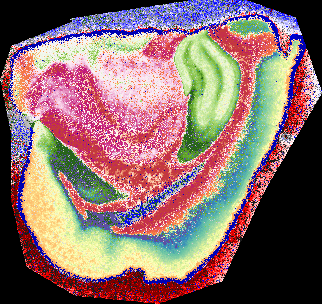

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_29304\1704540121.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')


9/9 [==============================] - 1s 91ms/step
Colored image without region specific normalization


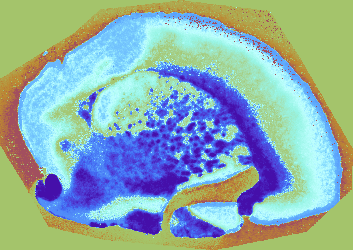

1D UMAP with per region color mapping


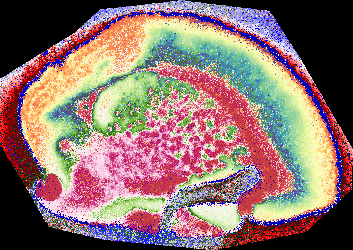

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_29304\1704540121.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  _cmap = plt.cm.get_cmap('gist_rainbow')


11/11 [==============================] - 2s 84ms/step
Colored image without region specific normalization


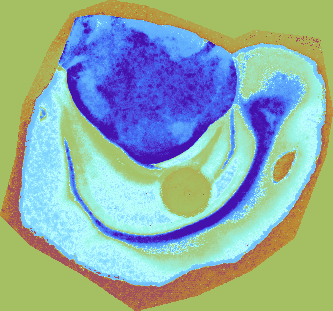

1D UMAP with per region color mapping


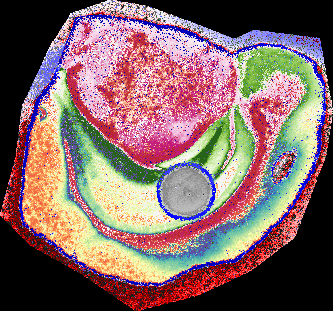

In [35]:
from PIL import Image
import cv2
import joblib
import numpy as np
from umap.parametric_umap import load_ParametricUMAP
import cmapy
import glob
from parametric_umap import normalize_image_grayscale, image_histogram_equalization
import tensorflow as tf
from sklearn.decomposition import non_negative_factorization
from visualizations import get_colors, visualizations_from_explanations
from matplotlib import pyplot as plt

def brain_nmf_semantic_segmentation(path_for_segmentation: str) -> np.ndarray:
    NUM_COMPONENTS = 5
    _cmap = plt.cm.get_cmap('gist_rainbow')
    colors_for_components = [
        np.array(
            _cmap(i)) for i in np.arange(
            0,
            1,
            1.0 /
            NUM_COMPONENTS)]    
    img_for_segmentation = np.load(path_for_segmentation)[:, :, 600 : ]
    H = np.load("h_cosegmentation.npy")
    img_for_segmentation = img_for_segmentation / (1e-6 + np.median(img_for_segmentation, axis=-1)[:, :, None])
    vector = img_for_segmentation.reshape((-1, img_for_segmentation.shape[-1]))

    w_new, h_new, n_iter = non_negative_factorization(vector, H=H, W=None, n_components=NUM_COMPONENTS, update_H=False, random_state=0)
    explanations = w_new.transpose().reshape(NUM_COMPONENTS, img_for_segmentation.shape[0], img_for_segmentation.shape[1])
    explanations[4, :] = 0
    spatial_sum_visualization, global_percentile_visualization, normalized_sum, normalized_percentile = visualizations_from_explanations(img_for_segmentation, explanations, colors_for_components)
    return normalized_sum.argmax(axis=0)
    

encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins.keras")
#encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_01_binarysearch_1_bin.keras")
lowres_paths = glob.glob("D:\\maldi\\tol_01_binarysearch_1_bin\\*.npy")
highres_paths = glob.glob("D:\\maldi\\tol_None_5_bins\\*.npy")

colors_maps = ["Spectral", "PiYG", "RdGy", "seismic"]

for path_for_segmentation, path_for_umap in zip(lowres_paths, highres_paths):
    semantic_segmentation_labels = brain_nmf_semantic_segmentation(path_for_segmentation)

    img = np.load(path_for_umap)
    img = img / (1e-6 + np.median(img, axis= -1)[:, :, None])
    transformed = encoder.predict(img.reshape(-1, img.shape[-1]), batch_size=10000)
    transformed = transformed.reshape((img.shape[0], img.shape[1]))
    result = []

    print('Colored image without region specific normalization')
    num_bins = 2048
    normalized_transformed = normalize_image_grayscale(transformed)
    normalized_transformed = image_histogram_equalization(normalized_transformed, img.max(axis=-1) > 0, num_bins) / (num_bins - 1)
    colored_image = np.uint8(normalized_transformed*255)
    colored_image = cv2.applyColorMap(colored_image, cmapy.cmap(colors_maps[0]))
    display(Image.fromarray(colored_image))
    
    
    print('1D UMAP with per region color mapping')

    #colors_maps = ["hsv", "twilight", "twilight_shifted", "seismic"]
    for index, value in enumerate(np.unique(semantic_segmentation_labels)):
        mask = np.uint8(semantic_segmentation_labels == value) * 255
        mask[img.max(axis=-1) == 0] = 0    
        masked_region = transformed.copy()
        mask[img.max(axis=-1) == 0] = 0
        masked_region[mask == 0] = 0

        num_bins = 2048
        masked_region = normalize_image_grayscale(masked_region)
        masked_region = image_histogram_equalization(masked_region, mask, num_bins) / (num_bins - 1)
        masked_region_gray = np.uint8(masked_region * 255)
        masked_region = cv2.applyColorMap(masked_region_gray, cmapy.cmap(colors_maps[value]))
        masked_region = masked_region[:, :, ::-1]
        masked_region[mask == 0] = 0
        
        result.append(masked_region)
    result = np.array(result)
    result = result.max(axis=0)    
    result[np.array(img.max(axis=-1) == 0)] = 0
    display(Image.fromarray(np.uint8(result)))